In [1]:
import numpy as np
import pandas as pd

from gensim import corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer
from w2v import train_word2vec 
import pickle, datetime
import difflib

import keras
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.utils import np_utils
from keras.layers import Input, Dense, Dropout, Flatten, Embedding, regularizers
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.merge import Concatenate
from keras import optimizers
from keras.preprocessing import sequence
from keras import backend as K

np.random.seed(0)

Using TensorFlow backend.


In [2]:
df = pd.read_csv('../../Datasets/SST1_dataset/Processed_SST1.tsv', sep='\t')

raw_docs_train      = df[df.split_ind == 1]['Phrases'].values
sentiment_train     = df[df.split_ind == 1]['Label'].values
raw_docs_test       = df[df.split_ind == 2]['Phrases'].values
sentiment_test      = df[df.split_ind == 2]['Label'].values
num_labels          = len(np.unique(sentiment_train))

N_TRAIN = len(raw_docs_train)
N_TEST = len(raw_docs_test)

In [3]:
#text pre-processing
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])
stemmer = SnowballStemmer('english')

print ("pre-processing train docs...")
processed_docs_train = []
for doc in raw_docs_train:
   tokens = word_tokenize(doc)
   filtered = [word for word in tokens if word not in stop_words]
   stemmed = [stemmer.stem(word) for word in filtered]
   processed_docs_train.append(stemmed)

print ("pre-processing test docs...")
processed_docs_test = []
for doc in raw_docs_test:
   tokens = word_tokenize(doc)
   filtered = [word for word in tokens if word not in stop_words]
   stemmed = [stemmer.stem(word) for word in filtered]
   processed_docs_test.append(stemmed)
    
processed_docs_all = np.concatenate((processed_docs_train, processed_docs_test), axis=0)

dictionary = corpora.Dictionary(processed_docs_all)
dictionary_size = len(dictionary.keys())

print ("converting to token ids...")
word_id_train, word_id_len = [], []
for doc in processed_docs_train:
    word_ids = [dictionary.token2id[word] for word in doc]
    word_id_train.append(word_ids)
    word_id_len.append(len(word_ids))

word_id_test, word_ids = [], []
for doc in processed_docs_test:
    word_ids = [dictionary.token2id[word] for word in doc]
    word_id_test.append(word_ids)
    word_id_len.append(len(word_ids))
        
seq_len = np.round((np.mean(word_id_len) + 2*np.std(word_id_len))).astype(int)

#pad sequences
x_train = sequence.pad_sequences(np.array(word_id_train), maxlen=seq_len)
x_test  = sequence.pad_sequences(np.array(word_id_test), maxlen=seq_len)
y_train = np_utils.to_categorical(sentiment_train, num_labels)
y_test  = np_utils.to_categorical(sentiment_test, num_labels)

pre-processing train docs...
pre-processing test docs...
converting to token ids...


In [6]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(9645, 21) (2210, 21) (9645, 5) (2210, 5)


# -------------------------------- Training model  -----------------------------------

### Model Paremeters

In [7]:
model_type    = 'CNN-rand'  # CNN-rand|CNN-non-static|CNN-static
embedding_dim = 25         # word2vec dim
vocab_size    = dictionary_size
max_sent_len  = seq_len
N_CATEGORY    = 5

### Generate word2vec 

In [8]:
if model_type in ['CNN-non-static', 'CNN-static']:
    embedding_wts = train_word2vec( np.vstack((x_train, x_test, x_valid)), 
                                    ind_to_wrd, num_features = embedding_dim)
    if model_type == 'CNN-static':
        x_train = embedding_wts[0][x_train]
        x_test  = embedding_wts[0][x_test]
#         x_valid = embedding_wts[0][x_valid]
        
elif model_type == 'CNN-rand':
    embedding_wts = None
    
else:
    raise ValueError("Unknown model type")

### Create model

In [9]:
batch_size   = 50
filter_sizes = [3,4,5]
num_filters  = 50
dropout_prob = (0.5, 0.8)
hidden_dims  = 50

l2_reg = 0.3

# Deciding dimension of input based on the model
input_shape = (max_sent_len, embedding_dim) if model_type == "CNN-static" else (max_sent_len,)
model_input = Input(shape = input_shape)

# Static model do not have embedding layer
if model_type == "CNN-static":
    z = Dropout(dropout_prob[0])(model_input)
else:
    z = Embedding(vocab_size, embedding_dim, input_length = max_sent_len, name="embedding", trainable=True)(model_input)
    z = Dropout(dropout_prob[0])(z)

# Convolution layers
z1 = Conv1D(    filters=num_filters, kernel_size=filter_sizes[0], 
                padding="valid", activation="relu", 
                strides=1)(z)
z1 = MaxPooling1D(pool_size =2)(z1)
z1 = Flatten()(z1)

z2 = Conv1D(    filters=num_filters, kernel_size=filter_sizes[1], 
                padding="valid", activation="relu", 
                strides=1)(z)
z2 = MaxPooling1D(pool_size=2)(z2)
z2 = Flatten()(z2)

z3 = Conv1D(    filters=num_filters, kernel_size=filter_sizes[2], 
                padding="valid", activation="relu",
                strides=1)(z)
z3 = MaxPooling1D(pool_size=2)(z3)
z3 = Flatten()(z3)

# Concatenate the output of all convolution layers
z = Concatenate()([z1, z2, z3])
z = Dropout(dropout_prob[1])(z)

z = Dense(hidden_dims, activation="relu")(z)
model_output = Dense(N_CATEGORY, activation="softmax")(z)
    
model = Model(model_input, model_output)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 21)            0                                            
____________________________________________________________________________________________________
embedding (Embedding)            (None, 21, 25)        345025                                       
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 21, 25)        0                                            
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 19, 50)        3800                                         
___________________________________________________________________________________________

### Train model 

In [10]:
if model_type == "CNN-non-static":
    embedding_layer = model.get_layer("embedding")
    embedding_layer.set_weights(embedding_wts)

model.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(0.1), metrics=["accuracy"])

res = model.fit(x_train, y_train, 
          batch_size = batch_size,
          epochs=50,
          validation_data=(x_test, y_test), verbose=2)

Train on 9645 samples, validate on 2210 samples
Epoch 1/50
2s - loss: 1.5728 - acc: 0.2668 - val_loss: 1.5826 - val_acc: 0.2308
Epoch 2/50
1s - loss: 1.5705 - acc: 0.2681 - val_loss: 1.5851 - val_acc: 0.2308
Epoch 3/50
1s - loss: 1.5700 - acc: 0.2702 - val_loss: 1.5811 - val_acc: 0.2308
Epoch 4/50
1s - loss: 1.5694 - acc: 0.2712 - val_loss: 1.5808 - val_acc: 0.2308
Epoch 5/50
1s - loss: 1.5699 - acc: 0.2667 - val_loss: 1.5821 - val_acc: 0.2308
Epoch 6/50
1s - loss: 1.5696 - acc: 0.2620 - val_loss: 1.5778 - val_acc: 0.2308
Epoch 7/50
1s - loss: 1.5693 - acc: 0.2598 - val_loss: 1.5792 - val_acc: 0.2765
Epoch 8/50
2s - loss: 1.5691 - acc: 0.2678 - val_loss: 1.5827 - val_acc: 0.2308
Epoch 9/50
1s - loss: 1.5693 - acc: 0.2647 - val_loss: 1.5825 - val_acc: 0.2308
Epoch 10/50
1s - loss: 1.5690 - acc: 0.2667 - val_loss: 1.5778 - val_acc: 0.2308
Epoch 11/50
2s - loss: 1.5697 - acc: 0.2699 - val_loss: 1.5808 - val_acc: 0.2308
Epoch 12/50
1s - loss: 1.5689 - acc: 0.2762 - val_loss: 1.5751 - val_a

In [12]:
import os
os.system('say done')

256

### Computing Accuracy

In [11]:
# Final evaluation of the model
scores = model.evaluate(x_train, y_train, verbose=0)
print("Train Accuracy: %.2f%%" % (scores[1]*100))

# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)

print("Test Accuracy: %.2f%%" % (scores[1]*100))

Train Accuracy: 44.60%
Test Accuracy: 37.92%


### Save the model

In [14]:
date = str(datetime.date.today() )
time = str(datetime.datetime.now().time())[:-7]

filename = '/home/shikhar/Datasets/Models/retry2_' + model_type + '_' + date + '_' +time;
with open( filename, 'wb') as output:
    pickle.dump([model.get_config(), model.get_weights(), model.history.history], output, pickle.HIGHEST_PROTOCOL)

### Plot the results

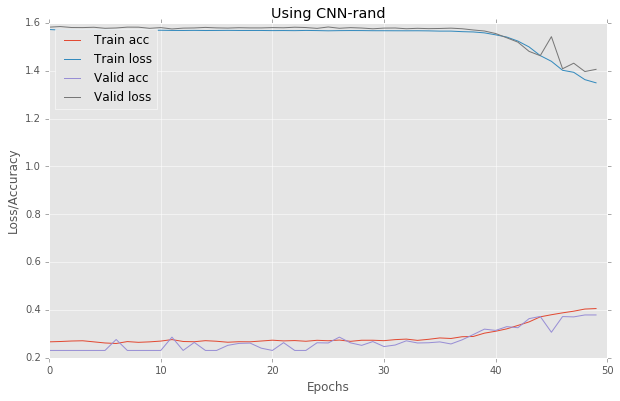

In [13]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.rcParams["figure.figsize"] = (10,6)
plt.plot(res.history['acc'])
plt.plot(res.history['loss'])
plt.plot(res.history['val_acc'])
plt.plot(res.history['val_loss'])
plt.legend(['Train acc','Train loss','Valid acc', 'Valid loss'], loc=2)
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.title('Using '+ model_type)
# imgName = 'Images/' + model_type + '_' + date + '_' + time + '.jpg'
# plt.savefig( imgName, dpi= 200, bbox_inches='tight', transparent=False)
plt.show()

### Continue from a pretrained model

In [15]:
# Loading saved data
import pickle

# filename = '/home/shikhar/Datasets/Models/3_CNN-static_2017-04-04_11:38:41'
with open( filename, 'rb') as input:
    out = pickle.load(input)

model.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(0.01), metrics=["accuracy"])
model.set_weights(out[1])

In [ ]:
res = model.fit(x_train, y_train,
          batch_size = batch_size,
          epochs=300,
          validation_data=(x_test, y_test), verbose=2)

Train on 9645 samples, validate on 2210 samples
Epoch 1/300
1s - loss: 1.3017 - acc: 0.4299 - val_loss: 1.3853 - val_acc: 0.3833
Epoch 2/300
1s - loss: 1.2928 - acc: 0.4286 - val_loss: 1.3861 - val_acc: 0.3810
Epoch 3/300
1s - loss: 1.2905 - acc: 0.4313 - val_loss: 1.3844 - val_acc: 0.3837
Epoch 4/300
1s - loss: 1.2811 - acc: 0.4323 - val_loss: 1.3843 - val_acc: 0.3851
Epoch 5/300
1s - loss: 1.2765 - acc: 0.4320 - val_loss: 1.3841 - val_acc: 0.3855
Epoch 6/300
1s - loss: 1.2733 - acc: 0.4345 - val_loss: 1.3856 - val_acc: 0.3837
Epoch 7/300
1s - loss: 1.2704 - acc: 0.4336 - val_loss: 1.3839 - val_acc: 0.3819
Epoch 8/300
1s - loss: 1.2671 - acc: 0.4376 - val_loss: 1.3835 - val_acc: 0.3842
Epoch 9/300
1s - loss: 1.2665 - acc: 0.4393 - val_loss: 1.3823 - val_acc: 0.3846
Epoch 10/300
1s - loss: 1.2575 - acc: 0.4403 - val_loss: 1.3831 - val_acc: 0.3864
Epoch 11/300
1s - loss: 1.2597 - acc: 0.4423 - val_loss: 1.3825 - val_acc: 0.3855
Epoch 12/300
2s - loss: 1.2566 - acc: 0.4389 - val_loss: 1.

1s - loss: 1.0684 - acc: 0.5122 - val_loss: 1.5219 - val_acc: 0.3747
Epoch 102/300
1s - loss: 1.0658 - acc: 0.5098 - val_loss: 1.5259 - val_acc: 0.3747
Epoch 103/300
1s - loss: 1.0646 - acc: 0.5131 - val_loss: 1.5211 - val_acc: 0.3724
Epoch 104/300
1s - loss: 1.0523 - acc: 0.5212 - val_loss: 1.5294 - val_acc: 0.3710
Epoch 105/300
1s - loss: 1.0641 - acc: 0.5182 - val_loss: 1.5265 - val_acc: 0.3742
Epoch 106/300
1s - loss: 1.0615 - acc: 0.5145 - val_loss: 1.5344 - val_acc: 0.3751
Epoch 107/300
1s - loss: 1.0594 - acc: 0.5142 - val_loss: 1.5281 - val_acc: 0.3747
Epoch 108/300
1s - loss: 1.0577 - acc: 0.5179 - val_loss: 1.5464 - val_acc: 0.3715
Epoch 109/300
1s - loss: 1.0536 - acc: 0.5184 - val_loss: 1.5384 - val_acc: 0.3747
Epoch 110/300
1s - loss: 1.0597 - acc: 0.5150 - val_loss: 1.5425 - val_acc: 0.3697
Epoch 111/300
1s - loss: 1.0584 - acc: 0.5157 - val_loss: 1.5489 - val_acc: 0.3697
Epoch 112/300
1s - loss: 1.0497 - acc: 0.5206 - val_loss: 1.5619 - val_acc: 0.3670
Epoch 113/300
1s -

1s - loss: 0.9340 - acc: 0.5774 - val_loss: 1.8747 - val_acc: 0.3679
Epoch 201/300
1s - loss: 0.9255 - acc: 0.5737 - val_loss: 1.8350 - val_acc: 0.3552
Epoch 202/300
1s - loss: 0.9279 - acc: 0.5725 - val_loss: 1.8281 - val_acc: 0.3656
Epoch 203/300
1s - loss: 0.9345 - acc: 0.5721 - val_loss: 1.8033 - val_acc: 0.3606
Epoch 204/300
1s - loss: 0.9386 - acc: 0.5756 - val_loss: 1.8177 - val_acc: 0.3688
Epoch 205/300
1s - loss: 0.9282 - acc: 0.5859 - val_loss: 1.8414 - val_acc: 0.3633
Epoch 206/300
1s - loss: 0.9187 - acc: 0.5879 - val_loss: 1.8773 - val_acc: 0.3656
Epoch 207/300
1s - loss: 0.9255 - acc: 0.5885 - val_loss: 1.8589 - val_acc: 0.3715
Epoch 208/300
1s - loss: 0.9261 - acc: 0.5796 - val_loss: 1.8477 - val_acc: 0.3620
Epoch 209/300
1s - loss: 0.9226 - acc: 0.5877 - val_loss: 1.8414 - val_acc: 0.3647
Epoch 210/300
1s - loss: 0.9244 - acc: 0.5828 - val_loss: 1.8733 - val_acc: 0.3638
Epoch 211/300
1s - loss: 0.9174 - acc: 0.5871 - val_loss: 1.8739 - val_acc: 0.3638
Epoch 212/300
1s -

### Save the model (marking as continued)

In [24]:
date = str(datetime.date.today() )
time = str(datetime.datetime.now().time())[:-7]

filename = '/home/shikhar/Datasets/Models/' + model_type + '_continued_' + date + '_' +time;
with open( filename, 'wb') as output:
    pickle.dump([model.get_config(), model.get_weights(), model.history.history], output, pickle.HIGHEST_PROTOCOL)

In [23]:
import os
os.system('say done')

256

In [24]:
files = [
    'CNN-rand_continued_2017-04-02_19:26:35',
    'CNN-rand_continued_2017-04-03_16:50:47',
    'CNN-rand_continued_2017-04-03_17:18:47'
]

In [25]:
train_acc, train_loss, val_acc, val_loss = [],[],[],[]

for file in files:
    filename = '/home/shikhar/Datasets/Models/'  + file
    with open( filename, 'rb') as input:
        out = pickle.load(input)
    train_acc += out[2]['acc']
    train_loss += out[2]['loss']
    val_acc += out[2]['val_acc']
    val_loss += out[2]['val_loss']

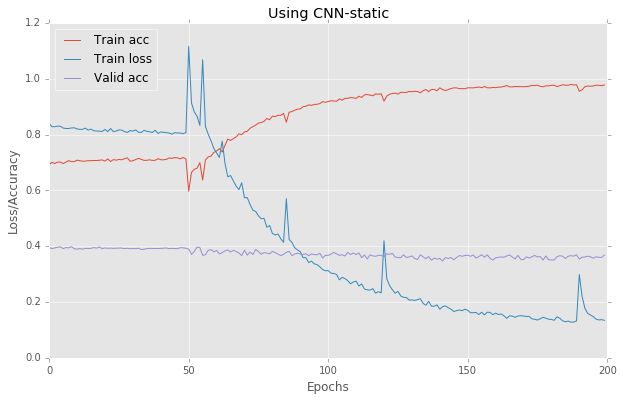

In [35]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(train_acc)
plt.plot(train_loss)
plt.plot(val_acc)
# plt.plot(val_loss)
plt.legend(['Train acc','Train loss','Valid acc', 'Valid loss'], loc=2)
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.title('Using '+ model_type)
date = str(datetime.date.today() )
time = str(datetime.datetime.now().time())[:-7]
imgName = 'Images/' + model_type + '_' + date + '_' + time + '.jpg'
plt.savefig( imgName, dpi= 200, bbox_inches='tight', transparent=False)
plt.show()